<a href="https://colab.research.google.com/github/raffieeey/MasterResearchAutoML/blob/master/h2oautoml/freedom/02A_H2OAutoml_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependecies for H2O automl

In [9]:
!pip install pmlb
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install pytictoc

In [0]:
#!pip uninstall h2o -y

## Installing H2O

In [11]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


## Getting the number of Cores

In [12]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

##Starting H2O

In [0]:
import h2o

In [14]:
h2o.init(nthreads=4,
                 min_mem_size="2048M",
                 max_mem_size="2048M")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,47 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,"14 days, 9 hours and 25 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_7a93dl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Creating the metrics for AUC and AUCpr (Binary classification)

In [15]:
%matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np



def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate","True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate","True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall","Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = (np.sum(labels)/len(labels))[0]
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall","Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

figure()

<Figure size 648x324 with 0 Axes>

## Creating all the metrics for Classification algorithm

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss
import numpy as np
import pandas as pd


class CheckBinomial:
  def __init__(self, checkunique):
    self._bintype = 'binomial' if pd.Series(checkunique).nunique() == 2 else 'multinomial'

  def MLMetrics(self):
    if self._bintype == 'binomial':
      return ['mean_per_class_error', 'AUC', 'logloss']
    elif self._bintype == 'multinomial':
      return ['mean_per_class_error', 'logloss']

class MetricsCalc:
  def __init__(self, truth, predictions):
    self.truth = truth.as_data_frame()
    self.predictions = predictions
    self._target = predictions.iloc[:,0]
    self._probabmax = np.max(predictions.iloc[:,1:], axis=1)
    self._probab = predictions.iloc[:,1:]
    self._type = 'binomial' if (self.truth.nunique() == 2).bool() else 'multinomial'

  def acc(self):
    return float(accuracy_score(self.truth,self._target))

  def auc(self):
    if self._type == "binomial":
      return float(roc_auc_score(self.truth, self._probabmax))
    elif self._type == "multinomial":
      return np.nan 

  def logloss(self):
    return float(log_loss(self.truth, self._probab))
  
  def cm(self):
    return confusion_matrix(self.truth, self._target)
  
  def f1(self):
    if self._type == "binomial":
      return float(f1_score(self.truth, self._target, average='binary'))
    elif self._type == "multinomial":
      return float(f1_score(self.truth, self._target, average='macro')) 

## Running H2O autoML with 
- 120 seconds
- Seed 69
- 2 Cores
- 2GB memory

- Tested for metrics: 
> - Mean per class error
> - AUC
> - Logloss

- Recorded for metrics: 
> - Mean per class error
> - AUC
> - Logloss
> - F1 score
> - Confusion Metrics

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 1752.033172 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,auc,logloss,aucpr,rmse,mse
StackedEnsemble_AllModels_AutoML_20200528_071000,0.212397,0.927983,0.293038,0.975193,0.300464,0.0902787
GBM_4_AutoML_20200528_071000,0.215047,0.924573,0.286387,0.974083,0.299988,0.0899926
XGBoost_grid__1_AutoML_20200528_071000_model_2,0.215161,0.923659,0.286257,0.973832,0.30187,0.0911255
XGBoost_grid__1_AutoML_20200528_071000_model_4,0.215784,0.927361,0.278869,0.975257,0.297527,0.0885223
GBM_2_AutoML_20200528_071000,0.215978,0.926873,0.281649,0.974986,0.298038,0.0888265



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_4_AutoML_20200528_071000',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200528_071000_model_2',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200528_071000_model_4',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
   

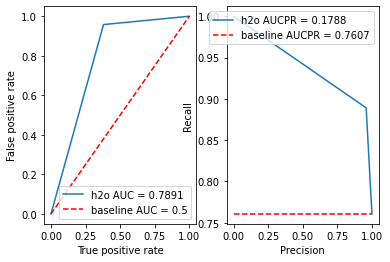

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 1706.690556 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,auc,logloss,aucpr,rmse,mse
XGBoost_grid__1_AutoML_20200528_073918_model_15,0,1,0.00465464,1,0.0147223,0.000216745
GBM_grid__1_AutoML_20200528_073918_model_59,0,1,0.015723,1,0.0171782,0.00029509
GBM_grid__1_AutoML_20200528_073918_model_41,0,1,0.00635517,1,0.0167963,0.000282115
XGBoost_grid__1_AutoML_20200528_073918_model_104,0,1,0.00142191,1,0.00406242,1.65032e-05
GBM_grid__1_AutoML_20200528_073918_model_10,0,1,0.0250266,1,0.0377308,0.00142361



{'backend': 'auto',
 'booster': 'gbtree',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 1.0,
 'col_sample_rate_per_tree': 0.8,
 'colsample_bylevel': 1.0,
 'colsample_bytree': 0.8,
 'distribution': 'bernoulli',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 15,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 5.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 5.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XGBo

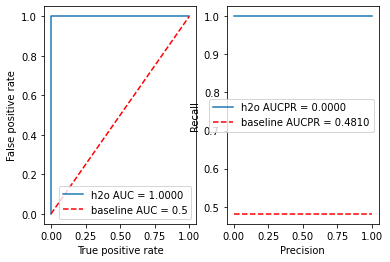

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 1598.352892 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,auc,logloss,aucpr,rmse,mse
GBM_grid__1_AutoML_20200528_080749_model_25,0.0977455,0.917432,0.17966,0.862307,0.209869,0.044045
XGBoost_grid__1_AutoML_20200528_080749_model_1,0.101308,0.912648,0.163637,0.871107,0.193865,0.0375837
GBM_grid__1_AutoML_20200528_080749_model_37,0.101437,0.918956,0.154476,0.877658,0.190326,0.0362239
GBM_3_AutoML_20200528_080749,0.101466,0.922298,0.148607,0.880027,0.184685,0.0341084
StackedEnsemble_BestOfFamily_AutoML_20200528_080749,0.101845,0.912525,0.140038,0.877724,0.182009,0.0331273



{'balance_classes': False,
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'check_constant_response': True,
 'checkpoint': None,
 'class_sampling_factors': None,
 'col_sample_rate': 0.7,
 'col_sample_rate_change_per_level': 1.0,
 'col_sample_rate_per_tree': 0.4,
 'custom_distribution_func': None,
 'custom_metric_func': None,
 'distribution': 'bernoulli',
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'histogram_type': 'AUTO',
 'huber_alpha': 0.9,
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.1,
 'learn_rate_annealing': 1.0,
 'max_abs_leafnode_pred': 1.7976931348623157e+308,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_depth': 8,
 'max_hit_ratio_k': 0,
 'max_runtime_secs': 0.0,
 'min_rows': 30.0,


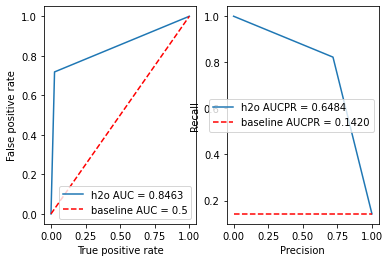

________________________________________________________________________________
*** Dataset Name: nursery ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 1856.568578 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20200528_083429_model_4,0.000195363,0.0174332,0.0400894,0.00160716
GBM_grid__1_AutoML_20200528_083429_model_5,0.00195896,0.00853831,0.0317907,0.00101065
GBM_1_AutoML_20200528_083429,0.00195896,0.0269438,0.0604953,0.00365969
XGBoost_3_AutoML_20200528_083429,0.00208564,0.0253612,0.0563635,0.00317685
GBM_2_AutoML_20200528_083429,0.00235325,0.0227992,0.0536351,0.00287672



{'backend': 'auto',
 'booster': 'dart',
 'build_tree_one_node': False,
 'calibrate_model': False,
 'calibration_frame': None,
 'categorical_encoding': 'AUTO',
 'checkpoint': None,
 'col_sample_rate': 1.0,
 'col_sample_rate_per_tree': 1.0,
 'colsample_bylevel': 1.0,
 'colsample_bytree': 1.0,
 'distribution': 'multinomial',
 'dmatrix_type': 'auto',
 'eta': 0.3,
 'export_checkpoints_dir': None,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'gamma': 0.0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'ignore_const_cols': True,
 'ignored_columns': [],
 'keep_cross_validation_fold_assignment': False,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'learn_rate': 0.3,
 'max_abs_leafnode_pred': 0.0,
 'max_bins': 256,
 'max_delta_step': 0.0,
 'max_depth': 5,
 'max_leaves': 0,
 'max_runtime_secs': 0.0,
 'min_child_weight': 1.0,
 'min_data_in_leaf': 0.0,
 'min_rows': 1.0,
 'min_split_improvement': 0.0,
 'min_sum_hessian_in_leaf': 100.0,
 'model_id': 'XGBoo

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20200528_090528,0.104095,0.23214,0.259091,0.0671283
XGBoost_3_AutoML_20200528_090528,0.105919,0.231992,0.259452,0.0673152
XGBoost_grid__1_AutoML_20200528_090528_model_11,0.106043,0.234465,0.259296,0.0672346
StackedEnsemble_BestOfFamily_AutoML_20200528_090528,0.106123,0.24489,0.265801,0.0706503
XGBoost_grid__1_AutoML_20200528_090528_model_12,0.106607,0.229709,0.259517,0.0673492



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_3_AutoML_20200528_090528',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200528_090528_model_11',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'XGBoost_grid__1_AutoML_20200528_090528_model_12',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20200528_094327,0.00646465,0.0408656,0.0911731,0.00831253
StackedEnsemble_BestOfFamily_AutoML_20200528_094327,0.00686869,0.0813301,0.124562,0.0155157
DeepLearning_grid__1_AutoML_20200528_094327_model_1,0.00767677,0.0212909,0.0754354,0.0056905
DeepLearning_grid__2_AutoML_20200528_094327_model_1,0.0123232,0.0308264,0.0952014,0.0090633
GBM_grid__1_AutoML_20200528_094327_model_1,0.0147475,0.0530224,0.112028,0.0125503



{'base_models': [{'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DeepLearning_grid__1_AutoML_20200528_094327_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'DeepLearning_grid__2_AutoML_20200528_094327_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'schema_name': 'KeyV3',
                             'schema_type': 'Key<Keyed>',
                             'schema_version': 3},
                  'name': 'GBM_grid__1_AutoML_20200528_094327_model_1',
                  'type': 'Key<Keyed>'},
                 {'URL': None,
                  '__meta': {'sc

In [17]:
from pmlb import classification_dataset_names, regression_dataset_names,fetch_data
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from pytictoc import TicToc
import pandas as pd
from pprint import pprint

df_result = pd.DataFrame(columns=["dataset_name", "metrics_recorded", "AUC", "ACC","logloss", "f1_score"])

preds = {}
cm_preds = {}
top_algo = {}
t = TicToc()


sel_clss_dtst = ['adult','agaricus-lepiota', 'churn', 'nursery', 'satimage','texture']
sel_rgrs_dtst = ['294_satellite_image','218_house_8L', '227_cpu_small', '503_wind', '344_mv','215_2dplanes']

ix = 0

for class_dtst in sel_clss_dtst:
  for metrics_test in ['mean_per_class_error']:
        print("_"*80)
        print(f"*** Dataset Name: {class_dtst} ***")
        df_result.loc[ix,"dataset_name"] = class_dtst
        df_result.loc[ix,"metrics_recorded"] = metrics_test
        X, y = fetch_data(class_dtst, return_X_y=True)
        c=CheckBinomial(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69, stratify=y)
        X_train = h2o.H2OFrame(X_train)
        X_test = h2o.H2OFrame(X_test)
        y_train = h2o.H2OFrame(y_train).asfactor()
        y_test = h2o.H2OFrame(y_test).asfactor()
        list_metrics = c.MLMetrics()
        aml = H2OAutoML(seed=69, max_runtime_secs=1800,sort_metric=metrics_test if metrics_test in list_metrics else None)
        t.tic()
        aml.train(x=X_train.columns, y=X_train.cbind(y_train)[:,-1].columns[0], training_frame=X_train.cbind(y_train))
        t.toc()    
        lb = aml.leaderboard
        top_algo[class_dtst] = aml.leader.actual_params
        print("*** Top algorithm: ***", lb.head(5))
        pprint(aml.leader.actual_params)
        preds[class_dtst] = aml.leader.predict(X_test).as_data_frame()
        p = MetricsCalc(y_test,preds[class_dtst])
        if c._bintype == "binomial":
          df_result.loc[ix,"AUC"] = p.auc()
          df_result.loc[ix,"ACC"] = p.acc()
          df_result.loc[ix,"logloss"] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          df_result.loc[ix,"f1_score"] = p.f1()
          prediction_summary( y_test.as_data_frame(), preds[class_dtst].iloc[:,0], "h2o")
          ix+=1
        elif c._bintype == "multinomial":
          df_result.loc[ix,"AUC"] = p.auc()
          df_result.loc[ix,"ACC"] = p.acc()
          df_result.loc[ix,"logloss"] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          df_result.loc[ix,"f1_score"] = p.f1()
          ix+=1

## Looking at the predictions

In [18]:
for i, val in enumerate(preds):
  print(preds[val])

      predict        p0        p1
0           1  0.034801  0.965199
1           1  0.459650  0.540350
2           0  0.970943  0.029057
3           1  0.034231  0.965769
4           0  0.966337  0.033663
...       ...       ...       ...
4880        1  0.035313  0.964687
4881        1  0.033448  0.966552
4882        1  0.039220  0.960780
4883        1  0.033520  0.966480
4884        1  0.074969  0.925031

[4885 rows x 3 columns]
     predict        p0        p1
0          0  0.999310  0.000690
1          0  0.994524  0.005476
2          0  0.998880  0.001120
3          0  0.997415  0.002585
4          1  0.007446  0.992554
..       ...       ...       ...
810        0  0.996191  0.003809
811        0  0.998825  0.001174
812        1  0.000904  0.999096
813        1  0.000917  0.999083
814        0  0.996440  0.003560

[815 rows x 3 columns]
     predict        p0        p1
0          0  0.934251  0.065749
1          0  0.984001  0.015999
2          0  0.967150  0.032850
3          0  0

## Saving the predictions

In [0]:
for i, val in enumerate(preds):
  preds[val].to_csv(f"{val}.csv")

## Looking at the AUC

In [20]:
df_result

,dataset_name,metrics_recorded,AUC,ACC,logloss,f1_score
0,adult,mean_per_class_error,0.67631,0.877175,0.291239,0.92228
1,agaricus-lepiota,mean_per_class_error,0.498046,1,0.00348793,1
2,churn,mean_per_class_error,0.102433,0.938,0.187139,0.766917
3,nursery,mean_per_class_error,NaN,1,0.0144925,1
4,satimage,mean_per_class_error,NaN,0.939441,0.190064,0.926938
5,texture,mean_per_class_error,NaN,0.721818,0.865629,0.668009


## Looking at the confusion matrix

In [21]:
import pprint
pprint.pprint(cm_preds)

{'adult': array([[ 725,  444],
       [ 156, 3560]]),
 'agaricus-lepiota': array([[423,   0],
       [  0, 392]]),
 'churn': array([[418,  11],
       [ 20,  51]]),
 'nursery': array([[432,   0,   0,   0],
       [  0, 427,   0,   0],
       [  0,   0, 404,   0],
       [  0,   0,   0,  33]]),
 'satimage': array([[151,   0,   0,   0,   2,   0],
       [  0,  68,   0,   0,   2,   0],
       [  1,   0, 130,   3,   0,   2],
       [  0,   0,  10,  46,   0,   7],
       [  1,   1,   0,   0,  67,   2],
       [  0,   0,   2,   6,   0, 143]]),
 'texture': array([[48,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 49,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 50,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0],
       [ 0,  0,  0, 

## Looking at the top algorithm used by the AutoML

In [22]:
top_algo

{'adult': {'base_models': [{'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'GBM_4_AutoML_20200528_071000',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'XGBoost_grid__1_AutoML_20200528_071000_model_2',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'XGBoost_grid__1_AutoML_20200528_071000_model_4',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'GBM_2_AutoML_20200528_071000',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'XGBoost_grid__1_AutoML_20200528_071000_model_10',
    'typ

In [0]:
from google.colab import files
df_result.to_csv("data_4.csv")
#files.download('data_4.csv')



with open('data_4.txt', 'w') as f:
    f.write(str(top_algo))

#files.download('data_4.txt')